Tristan Moser
<br>



# Background

Education in the United States is facing two major issues. First, year after year our students’ performance on common material is poor when compared to other countries in the world (sometimes even below average according to the Organization for Economic Cooperation and Development). This is more than just a matter of national pride. Our quality of life as a nation depends greatly on the education of our citizens. A study found that, “a one percent increase in the high school completion rate of all men ages 20-60 would save the United States as much as $1.4 billion per year in reduced costs from crime incurred by victims and society at-large” (1). It is obvious that we should employ efforts to increase high school graduation rates, but how? This leads into the second issue facing American education.


Many Americans believe that teachers are not paid what they deserve and that this causing a lower quality education being given to US students. Further, they argue that an increase in teacher salary would help attract better teachers which in turn have the capacity to increase student performance.

The purpose of this study is to determine if higher teacher salaries do in fact foster a higher high school graduation rate. The results should inform government agencies of whether it should allocate more funding to teacher salaries.

--------------
# Data

The data used in this study is from the Colorado Department of Education (CDE) from 2013 to 2017 (2). This source was chosen because of the good data collection practices employed in Colorado and because there are 189 school districts within the state of Colorado. This allows for a decent sample size and a good deal of variation between the districts so that trends can be analyzed. The years were limited because comprehensive data was unavailable for years previous to 2013.

To collect the data, I downloaded a plethora of CSV files from the Colorado Department of Education's website: https://www.cde.state.co.us/cdereval. These files contained a lot of specific information for each school district in each year, but there were many characteristics that were deemed not relevant for this study. As such, the following data were collected as relevant variables (variable names in parentheses):

  - **Average Teacher Salary** (*Average Salary*)
  - **Teacher Ethnicity Percentage** (*Teacher Pct Minority*)
  - **Student to Teacher Ratios** (*Pupil/Teacher Ratio*)
  - **High School Graduation Rates** (*All Students/Male/Female Graduation Rate*)
  - **Number of Enrolled Students** (*K-12 COUNT*)
  - **Percentage of Students eligible for Free or Reduced Lunch programs** (*% FREE AND REDUCED*)
  - **Student Ethnicity Percentages** (*Student Pct Minority*)
  - **Number of Students enrolled in Advanced Placement Courses** (*Total/Male/Female AP Enrollment*)
  
In addition to combining the various datasets, there were also many variables that were recorded as the wrong datatypes. For example, teacher salaries were recorded as string entries instead of numerical values. To correct these errors, I found the Python Pandas library to be extremely useful. In this case string characters such as "$", ".", and "," could easily be removed using the _.replace_ function. Entire column datatypes were also easily adjusted with the _.astype()_ function. 

Because of the great record keeping on part of the CDE, there were no missing data entries or other severe complications. A complete documentation of the data combining and initial cleaning can be found in the **Data.ipynb** file provided with this report.

Once all of the data was consolidated into one file, **Compiled_Data.csv**, I began to visualize the data to find and deal with outliers. This process is oulined below:

In [1]:
#Library Imports

import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

#Seaborn has a deprecation warning that has not been resolved yet
#I supress the warnings so as to avoid them being thrown every time I plot a graph
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy import linalg as la
from sklearn.utils import resample

#Read in the data
data = pd.read_csv('Compiled_Data.csv')

In order to determine the precense of outliers, it is necessary to look at the distribution of key variables. The following shows boxplots for Average Teacher Salary, Graduation Rates, and Free/Reduced Lunch Eligibility.

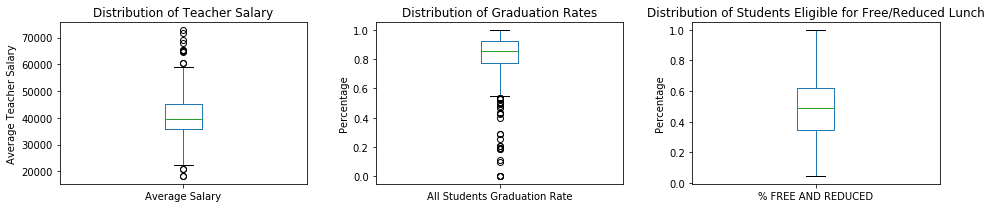

In [2]:
#Create subplots
f, ax = plt.subplots(1,3, sharex=False,figsize=(14,3))

#Teacher Salary Plot
data['Average Salary'].plot(kind='box',ax=ax[0])
ax[0].set_title('Distribution of Teacher Salary')
ax[0].set_ylabel('Average Teacher Salary')

#Graduation Rate Plot
data['All Students Graduation Rate'].plot(kind='box',ax=ax[1])
ax[1].set_title('Distribution of Graduation Rates')
ax[1].set_ylabel('Percentage')

#Free/Reduced Lunch Eligibility Plot
data['% FREE AND REDUCED'].plot(kind='box',ax=ax[2])
ax[2].set_title('Distribution of Students Eligible for Free/Reduced Lunch')
ax[2].set_ylabel('Percentage')

plt.tight_layout()

From the graphs, it is clear that there are some major outliers in the sample. First, it appears that while there is a good amount of variation in the Average Teacher Salary, there is cause for concern in districts where the salary is above ~60,000 or below ~21,000. To avoid this, the sample is limited to salaries with that specified range.

There are also significant outliers that appear in the Graudation Rates plot. This is especially concerning when looking at the extremely low rates. For my analysis, I want to see the effect of Teacher Salary on Graduation rates, but it needs to be reasonable. A district with a graduation rate below 50% or 60% likely has some other unique characteristics (online district, troubled youth district, etc.) that it would be hard to capture given the data. So, I will limit my data to districts with a graduation rate of at least 60%.

There appears to be no issue with the free/reduced lunch eligibility variable while there is still a good amount of variation. This suggests that there are equally as many districts in poor areas as in wealthy areas. 

In [3]:
#Remove Salary outliers
data = data[(data['Average Salary']>24000) & (data['Average Salary']<60000)]

#Remove Graduation outliers
data = data[data['All Students Graduation Rate']>.6]
data = data[data['Female Graduation Rate']>.6]
data = data[data['Male Graduation Rate']>.6]

Other variables to look at are AP enrollment and Student to Teacher Ratios. To evaluate these variables, I plot their distributions in histograms.

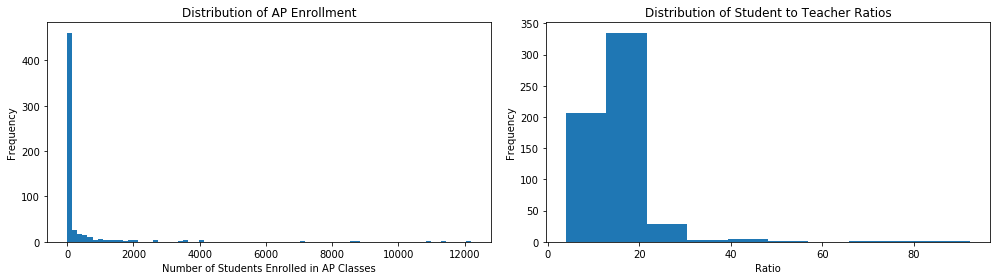

In [4]:
#Create subplots
f, ax = plt.subplots(1,2, sharex=False,figsize=(14,4))

#AP Enrollment Plot
data['Total AP Enrollment'].plot(kind='hist',bins=80,ax=ax[0])
ax[0].set_title('Distribution of AP Enrollment')
ax[0].set_xlabel('Number of Students Enrolled in AP Classes')

#Student to Teacher Ratio Plot
data['Pupil/Teacher Ratio'].plot(kind='hist',ax=ax[1])
ax[1].set_title('Distribution of Student to Teacher Ratios')
ax[1].set_xlabel('Ratio')

plt.tight_layout()

Looking at the AP Enrollment graph clearly shows that the data is not evenly distributed at all. In fact, this variable does not seem like it will be that informative of a characteristic to look at. Instead, it will be more beneficial to look at whether a district has AP enrollment or not. I will have to create a new feature that shows this new idea.

There are also some significant outliers in the Student to Teacher Ratio plot. As such, I will limit the sample to only include those with ratios below 40.

In [5]:
#Because I have dropped entries before, I need to reindex before creating the new variable
data = data.reset_index()

#Create new variable ap
#This represents whether a district has AP enrollment or not
data['AP Presence'] = 0
for ii in range(len(data)):
    if data['Total AP Enrollment'][ii] > 0 :
        data['AP Presence'][ii] = 1
        
#Drop Student to Teacher Ratio Outliers
data = data[data['Pupil/Teacher Ratio']<40]

--------------
# Analysis
<br>

## Visual Analysis

With the data ready, I begin to plot it to get an idea of what the overall trends are. This is accomplished by viewing some simple comparisons. It is important to note that while these visualizations offer great insight into the trends, they cannot by themselves determine a definite causal relationship. That will be treated in the numerical analysis section of the project.

First, I look at the question I am trying to solve: Is there a relationship between Teacher Salary and Graduation Rates? The following shows three plots that show the correlation between graduation rates (All Students, Female, and Male) and the Average Teacher Salary.

Text(0,0.5,'Male Graduation Rate')

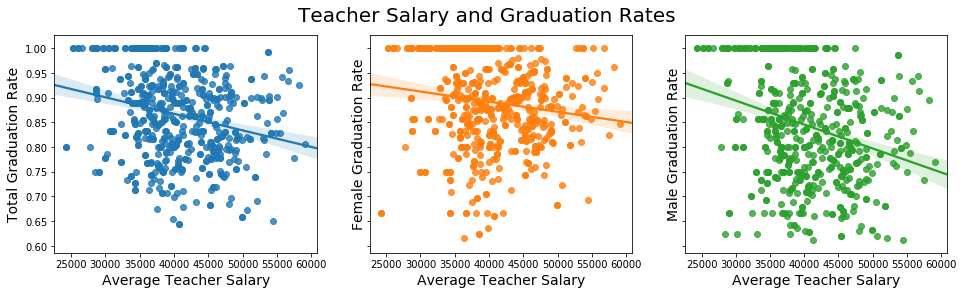

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4),sharey=True)
fig.suptitle('Teacher Salary and Graduation Rates',fontsize=20)

#Total Student Graduation Rate vs. Teacher Salary
sns.regplot(x=data['Average Salary'],y=data['All Students Graduation Rate'],ax=axes[0])
axes[0].set_xlabel('Average Teacher Salary',fontsize=14)
axes[0].set_ylabel('Total Graduation Rate',fontsize=14)

#Female Graduation Rate vs. Teacher Salary
sns.regplot(x=data['Average Salary'],y=data['Female Graduation Rate'],ax=axes[1])
axes[1].set_xlabel('Average Teacher Salary',fontsize=14)
axes[1].set_ylabel('Female Graduation Rate',fontsize=14)

#Male Graduation Rate vs. Teacher Salary
sns.regplot(x=data['Average Salary'],y=data['Male Graduation Rate'],ax=axes[2])
axes[2].set_xlabel('Average Teacher Salary',fontsize=14)
axes[2].set_ylabel('Male Graduation Rate',fontsize=14)

These plots show some interesting and somewhat unexpected correlations. Across all three graduation rates, there appears to be a negative correlation between the graduation rate and how much a district pays their teachers. Interestingly, the effect appears to have a steep effect on the male graduation rate specifically. 

While there does appear to be strong correlations, this does not imply that increasing Teacher Salary will necessarily cause a lower graduation rate for the district. Instead, the correlations seen here may be caused by other underlying correlations. So, it is necessary to look into other relationships.

Specifically, it is interesting to not the correlation between Teacher Salary and AP class enrollment. Since the AP Class Enrollment variable is a binary variable, the results are shown in two plots:

1) The Average Teacher Salary among districts with and without AP Enrollment


2) A Logistic Regression plot

Text(0,0.5,'AP Presence')

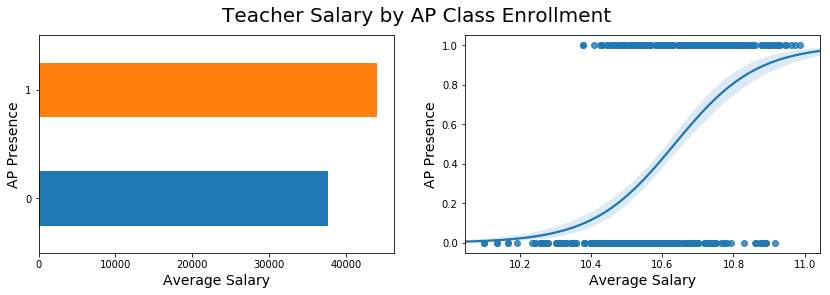

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
fig.suptitle('Teacher Salary by AP Class Enrollment',fontsize=20)

#Teacher Salary and AP Enrollment Correlation Plot
data.groupby('AP Presence')['Average Salary'].mean().plot(kind='barh',ax=axes[0])
axes[0].set_xlabel('Average Salary',fontsize=14)
axes[0].set_ylabel('AP Presence',fontsize=14)

#Teacher Salary and AP Enrollment Logistic Regression Plot
sns.regplot(data['Average Salary'].apply(np.log),data['AP Presence'],logistic=True,ax=axes[1])
axes[1].set_xlabel('Average Salary',fontsize=14)
axes[1].set_ylabel('AP Presence',fontsize=14)

The results of both plots show a positive correlation between Average Salary and AP Class Enrollment. This seems to suggest that the quality of education does increase as districts pay their teachers more. This would seem to confirm one's logic since higher qualified teachers should be getting paid more.

Other interesting relationships to view are how poverty and student minority percentages affect the graduation rate. Since I do not have access to a level of wealth for the district, I use the Free/Reduced Lunch eligibility variable as a proxy since students have to meet low enough wealth levels to qualify for the benefits.

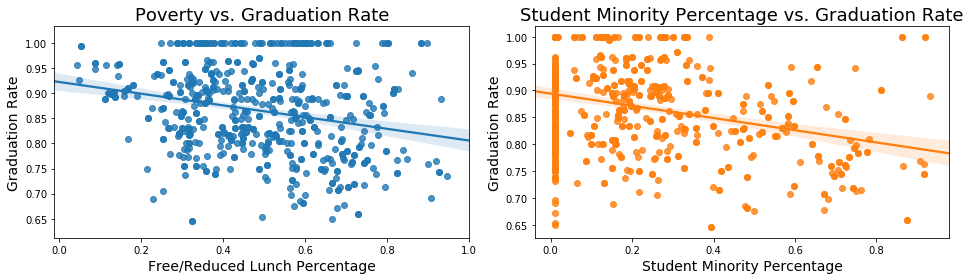

In [8]:
#Create subplots
f, ax = plt.subplots(nrows=1, ncols=2, sharex=False,figsize=(14,4))

#Poverty Plot
sns.regplot(x=data['% FREE AND REDUCED'],y=data['All Students Graduation Rate'],ax=ax[0])
ax[0].set_title('Poverty vs. Graduation Rate',fontsize=18)
ax[0].set_xlabel('Free/Reduced Lunch Percentage',fontsize=14)
ax[0].set_ylabel('Graduation Rate',fontsize=14)

#Percent Minority Plot
sns.regplot(x=data['Student Pct Minority'],y=data['All Students Graduation Rate'],ax=ax[1])
ax[1].set_title('Student Minority Percentage vs. Graduation Rate',fontsize=18)
ax[1].set_xlabel('Student Minority Percentage',fontsize=14)
ax[1].set_ylabel('Graduation Rate',fontsize=14)

plt.tight_layout()

Both of these plots show that poorer districts and those with a higher percentage of minority students tend to have lower graduation rates. To see if these variables could be biasing the effect of Teacher Salary on Graduation Rates, I look at the correlations between these two variables and the Average Salary.

Text(0,0.5,'Average Teacher Salary')

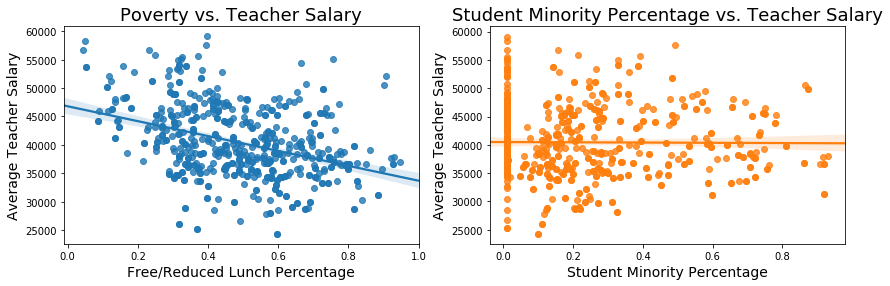

In [9]:
#Create subplots
f, ax = plt.subplots(nrows=1, ncols=2, sharey=False,sharex=False,figsize=(14,4))

#Poverty Plot
sns.regplot(x=data['% FREE AND REDUCED'],y=data['Average Salary'],ax=ax[0])
ax[0].set_title('Poverty vs. Teacher Salary',fontsize=18)
ax[0].set_xlabel('Free/Reduced Lunch Percentage',fontsize=14)
ax[0].set_ylabel('Average Teacher Salary',fontsize=14)

#Percent Minority Plot
sns.regplot(x=data['Student Pct Minority'],y=data['Average Salary'],ax=ax[1])
ax[1].set_title('Student Minority Percentage vs. Teacher Salary',fontsize=18)
ax[1].set_xlabel('Student Minority Percentage',fontsize=14)
ax[1].set_ylabel('Average Teacher Salary',fontsize=14)

Teacher Salaries appear to be negatively correlated with Free/Reduced Lunch Eleigibility even though both variables were shown to be negatively correlated with Graduation Rates. Couple that with Teacher Salaries not having any significant correlation with Student Minority Percentage and it is not clear what the exact underlying relationship is. 

Next, I evaluate the relationship between a district's Graduation Rate and its Student to Teacher Ratio. It has been well documented that smaller class sizes leads to student success and higher graduation rates (3). This next figure will check if that relationship is observed with my data.

Text(0.5,0,'Student to Teacher Ratio')

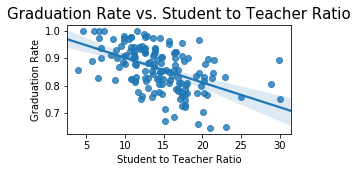

In [10]:
#Student to Teacher Ratio and Graduation Rates plot
plt.figure(figsize=(4,2))
sns.regplot(y=data.groupby('Orgnazation Name')['All Students Graduation Rate'].mean(),x=data.groupby('Orgnazation Name')['Pupil/Teacher Ratio'].mean())
plt.title('Graduation Rate vs. Student to Teacher Ratio',fontsize=15)
plt.ylabel('Graduation Rate',fontsize=10)
plt.xlabel('Student to Teacher Ratio',fontsize=10)

With the obvious negative relationship confirmed, the next question to answer now that we have found an interesting relationship is "How do Student to Teacher Ratios relate to Teacher Salaries?" If a low Student to Teacher Ratio is correlated with a high graduation rate, then maybe the Teacher Salary can influence Graduation Rates in an indirect way.

Text(0,0.5,'Student to Teacher Ratio')

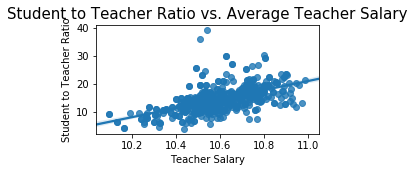

In [11]:
#Student to Teacher Ratio and Average Salary Correlation plot
plt.figure(figsize=(4,2))
sns.regplot(data['Average Salary'].apply(np.log),data['Pupil/Teacher Ratio'])
plt.title('Student to Teacher Ratio vs. Average Teacher Salary',fontsize=15)
plt.xlabel('Teacher Salary',fontsize=10)
plt.ylabel('Student to Teacher Ratio',fontsize=10)

In contrast to what teachers may hope, this figure suggests that increasing the a district's Teacher Salary is correlated with a higher Student to Teacher Ratio (which from the last figure would indicate a lower Graduation Rate holding everything else constant). Still, it may be that since the Student to Teacher Ratio is so positively correlated with Teacher Salary and negatively correlated with Graduation Rates, that the Student to Teacher Ratio bias the initial correlation graph and may be why Teacher Salary appears to be so negatively correlated with Graduation Rates.

--------------
## Numerical Analysis

While the visual analysis helps shed insight into obvious trends, it does not leave us with a very satisfying answer as to the effect of Teacher Salaries on Graduation Rates. Luckily, a more precise answer can be obtained through numerical analysis.

For this analysis, I will be finding the Least Squares solution to this problem. Specifically, I will look to solve the following equation:

### $$Ax = B$$

Where A is a matrix consisting of independent variables (Teacher Salary, Student to Teacher Ratio, etc.) from the data that have an effect on the dependent variable (Graduation Rate) which is represented in the vector B. Solving this equation will give a best linear fit represented by x. More particularly, it will show how a unit increase in an independent variable effects the Graduation Rate. Because the effect of a one unit increase ($1) in Average Teacher Salary is such a small and insignificant measure, I take the log of that variable. This allows me to interpret the Least Squares value for that variable in terms of the effect of a 1 percent increase instead of one unit increase.

In [12]:
#Gather Independent Variables to compose Matrix A
independent = [col for col in data.columns if col not in ['index','Organization Code','Orgnazation Name',
                                'All Students Graduation Rate','Female Graduation Rate','Male Graduation Rate',
                                'Teacher Count','Total FTE','Male AP Enrollment','Female AP Enrollment',
                                'Total AP Enrollment','AP Presence','Year']]

#Create Matrix A
A = data[independent]

#Log Large variables 
A['Average Salary'] = A['Average Salary'].apply(np.log)
A['K-12 COUNT'] = A['K-12 COUNT'].apply(np.log)

#Create Vector B
B = data['All Students Graduation Rate']

To solve for the Least Squares solution, I take a QR decomposition approach. Decomposing the matrix A into matrices Q and R allows for the solution to be found much faster since there is no need to calculate the inverse of the matrix A since I can use back matrix multiplication instead. While this speed is likely not significant when calculating it one time, it will become a factor when I calculate the confidence intervals as they require many iterations. 

In [13]:
#Least Squares Ax=B solution finder
def least_squares(A, b):
    #Calculate QR decomposition of Matrix A
    q,r = la.qr(A, mode='economic')
    #Back multiply Q inverse (transpose)
    qtb = np.transpose(q).dot(b)
    #Solve Rx=Qb with triangular
    x = la.solve_triangular(r,qtb)
    
    #Return Least Squares solutions
    return x

In [14]:
#Compile Results from Least Squares
df = pd.DataFrame(least_squares(A,B),index=list(A.columns),columns=['Least Squares Value'])
df

,Least Squares Value
Student Pct Minority,-0.030134
% FREE AND REDUCED,-0.136484
K-12 COUNT,-0.031010
Pupil/Teacher Ratio,-0.003028
Teacher Pct Minority,0.023874
Average Salary,0.111251


Many of these Least Squares solutions confirm what was seen in the visual analysis. The student to teacher ratio and the percentages of minority students and students eligible for free/reduced lunch all have negative values indicating that they negatively affect graduation rates.

The really interesting value is that the Average Teacher Salary has a positive value of 0.111251. This indicates that a one percent increase in a district's Teacher Salary actually increases a district's Graduation Rate by 0.00111251, contrary to what the visualizations suggested. 

Before accepting these solutions, it is necessary to see if they are reasonable. I check for the validity of the solutions by calculating confidence intervals by taking 1000 random samples from my A and B matrices and calculating the Least Squares solution for each pair. 

(array([1, 2, 3, 4, 5, 6]), <a list of 6 Text xticklabel objects>)

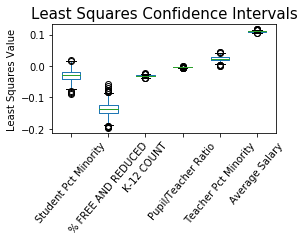

In [15]:
#Resample matrices A and B 1000 times
n_bootstraps = 1000
bootstrap_A = []
bootstrap_B = []
for ll in range(n_bootstraps):
    sample_A, sample_B = resample(A, B)
    bootstrap_A.append(sample_A)
    bootstrap_B.append(sample_B)

#Gather Least Squares Results for each sample pair
coeffs = []
for mat in range(len(bootstrap_A)):
    coeffs.append(least_squares(bootstrap_A[mat],bootstrap_B[mat]))

#Create Coefficient DataFrame
coef_df = pd.DataFrame(coeffs, columns=A.columns)

#Confidence Interval Coefficient Plot
coef_df.plot(kind='box',figsize=(4,2))
plt.title('Least Squares Confidence Intervals',fontsize=15)
plt.ylabel('Least Squares Value',fontsize=10)
plt.xticks(rotation=50,fontsize=10)

As the figure shows above, the positive Average Teacher Salary Least Squares value appears to reliable since every sample pair came out to be positive. The same cannot be said for the Student Minority Percentage and Student to Teacher Ratio values as both seem to hover on both sides of zero.

-----
# Conclusion

This purpose of this project was to determine the relationship between Teacher Salaries and Graduation Rates. After visual and numerical analysis, it has been determined that a one percent increase in the amount a district pays its teachers (on average) will increase Graduation Rates by approximately 0.0011. This estimate was shown to be significant as its confidence intervals contain only positive values. These results translate to a ten percent increase in salary having an effect of increasing the graduate percentage by approximately one percent. This small number can have an enormous impact. Not only will student acheivement increase, but as a result of higher education, there will be less crime according to Lochner (1). 

While the results shown here reflect the school districts in Colorado, local governments across the United States should strongly consider how increasing their teachers' salaries could help benefit their communities.

--------
# References

(1) Lochner, Lance and Enrico Moretti. 2004. The effect
of education on crime: Evidence from prison inmates, arrests, and self-reports.” American Economic Review. Vol.
94(1)

(2) Colorado Department of Education Statistics: https://www.cde.state.co.us/cdereval

(3) Finn, J. D., Gerber, S. B., & Boyd-Zaharias, J. (2005). Small Classes in the Early Grades, Academic Achievement, and Graduating From High School. Journal of Educational Psychology, 97(2), 214-223.